In [1]:
# depth_to_space

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

/home/ailab/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get data
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2023-01-15 10:16:41.839312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:16:41.843145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:16:41.843251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 10:16:41.843513: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# process data

def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [4]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 4
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(load_image_test)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [5]:
# monitor
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

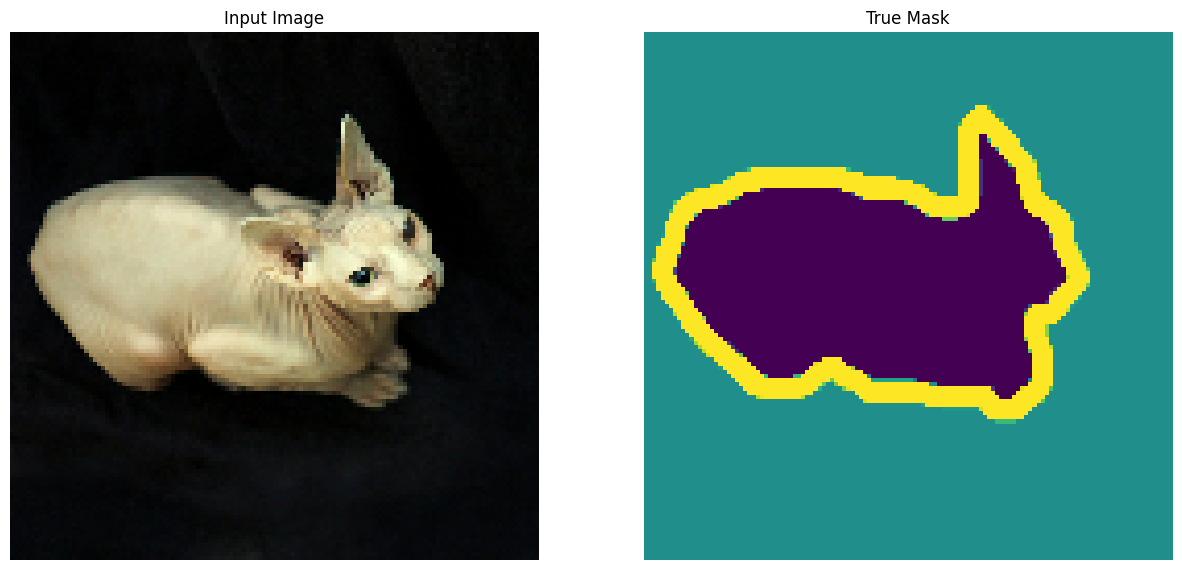

In [6]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
    display([sample_image, sample_mask])

In [7]:
inputs = tf.keras.layers.Input(shape=[128, 128, 3])    
x = inputs  

r = 2

# block 1
x = tf.keras.layers.Conv2D(64, 9, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# block 2
x = tf.keras.layers.Conv2D(128, 9, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# block 3
x = tf.keras.layers.Conv2D(256, 5, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# block 4
x = tf.keras.layers.Conv2D(512, 5, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# block 5
x = tf.keras.layers.Conv2D(512, 3, padding='same', activation='LeakyReLU')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D()(x)

# upsampling
x = tf.keras.layers.Conv2D(512*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.BatchNormalization()(x)

# upsampling
x = tf.keras.layers.Conv2D(256*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.BatchNormalization()(x)

# upsampling
x = tf.keras.layers.Conv2D(128*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.BatchNormalization()(x)

# upsampling
x = tf.keras.layers.Conv2D(64*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.BatchNormalization()(x)

# upsampling
x = tf.keras.layers.Conv2D(32*r*r, 3, padding='same', activation='LeakyReLU')(x)
x = tf.nn.depth_to_space(x, r)
x = tf.keras.layers.Conv2D(3, 3, padding='same')(x)

model = tf.keras.Model(inputs=[inputs], outputs=[x])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      15616     
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       663680    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512   

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):        
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/20


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
2023-01-15 10:16:45.363394: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2023-01-15 10:16:45.834319: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:16:45.834680: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:16:45.834693: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-15 10:16:45.835018: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-15 10:16:45.835053: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas loca

  4/920 [..............................] - ETA: 21s - loss: 1.1577 - accuracy: 0.4559  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0098s vs `on_train_batch_end` time: 0.0115s). Check your callbacks.


920/920 [==============================] - ETA: 0s - loss: 0.7439 - accuracy: 0.6887

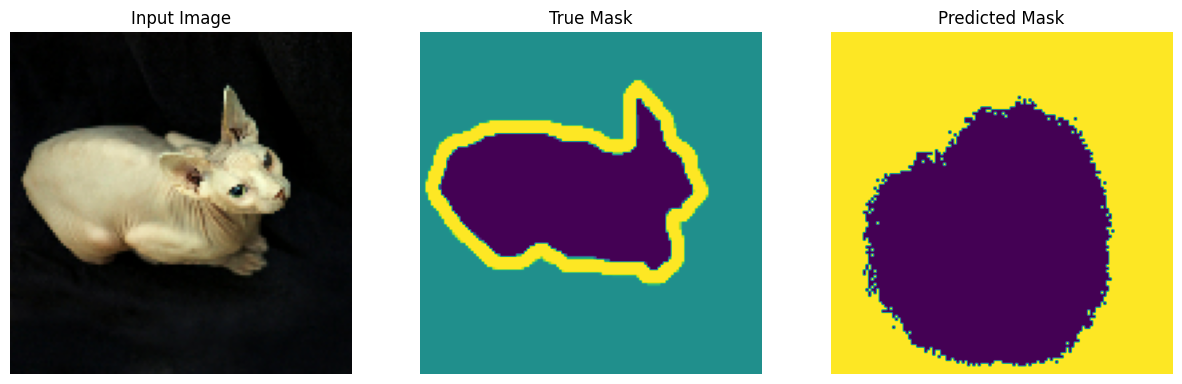


Sample Prediction after epoch 1

920/920 [==============================] - 27s 26ms/step - loss: 0.7439 - accuracy: 0.6887 - val_loss: 0.7282 - val_accuracy: 0.6982
Epoch 2/20
918/920 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.7316

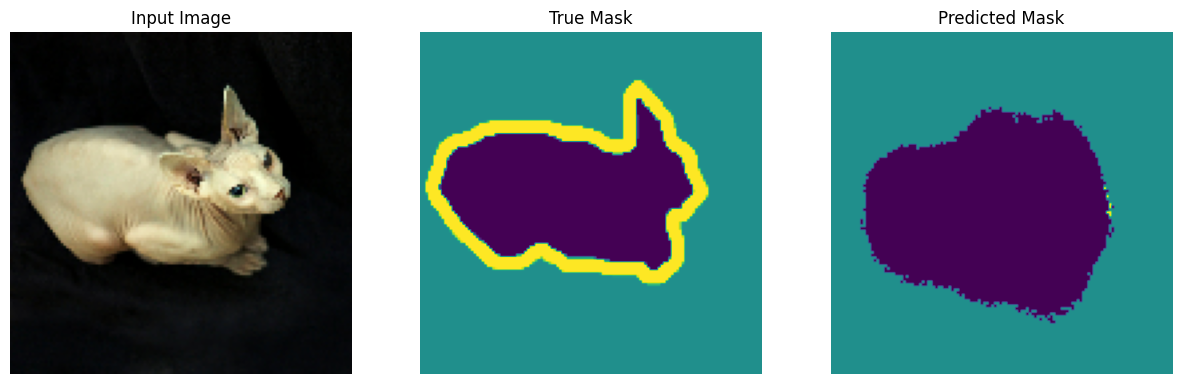


Sample Prediction after epoch 2

920/920 [==============================] - 23s 25ms/step - loss: 0.6559 - accuracy: 0.7315 - val_loss: 0.6599 - val_accuracy: 0.7287
Epoch 3/20
918/920 [============================>.] - ETA: 0s - loss: 0.5983 - accuracy: 0.7544

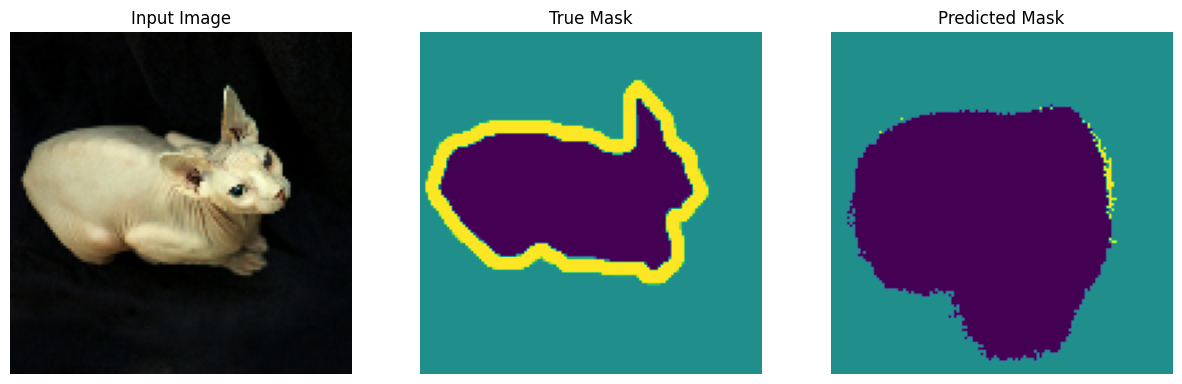


Sample Prediction after epoch 3

920/920 [==============================] - 23s 25ms/step - loss: 0.5981 - accuracy: 0.7544 - val_loss: 0.6123 - val_accuracy: 0.7466
Epoch 4/20
918/920 [============================>.] - ETA: 0s - loss: 0.5539 - accuracy: 0.7709

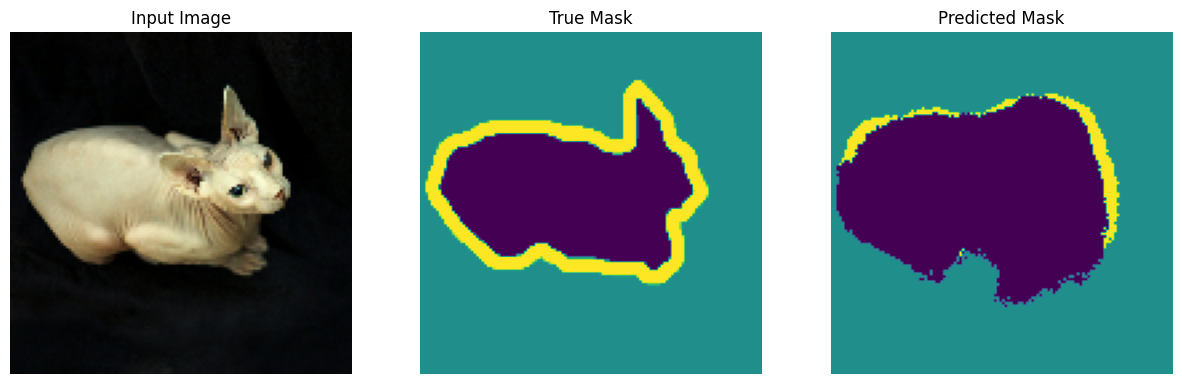


Sample Prediction after epoch 4

920/920 [==============================] - 23s 25ms/step - loss: 0.5538 - accuracy: 0.7710 - val_loss: 0.5425 - val_accuracy: 0.7725
Epoch 5/20
919/920 [============================>.] - ETA: 0s - loss: 0.5154 - accuracy: 0.7864

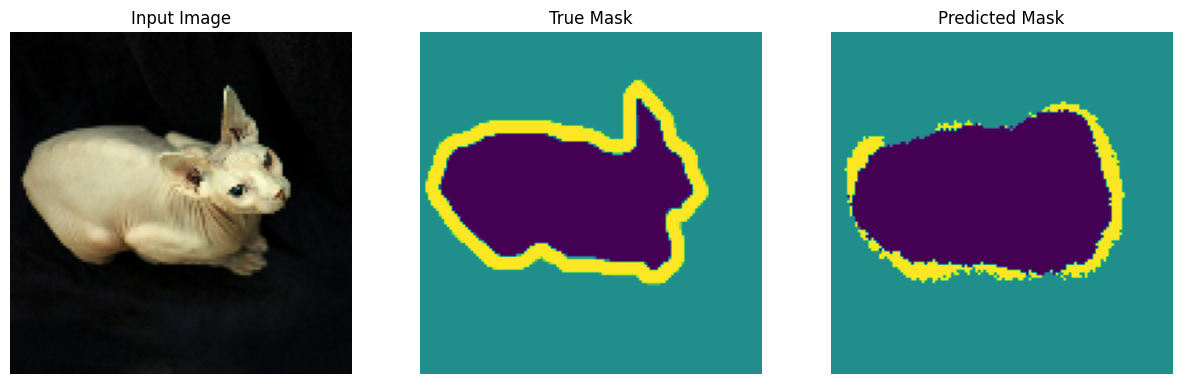


Sample Prediction after epoch 5

920/920 [==============================] - 23s 25ms/step - loss: 0.5154 - accuracy: 0.7863 - val_loss: 0.5279 - val_accuracy: 0.7824
Epoch 6/20
920/920 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.8001

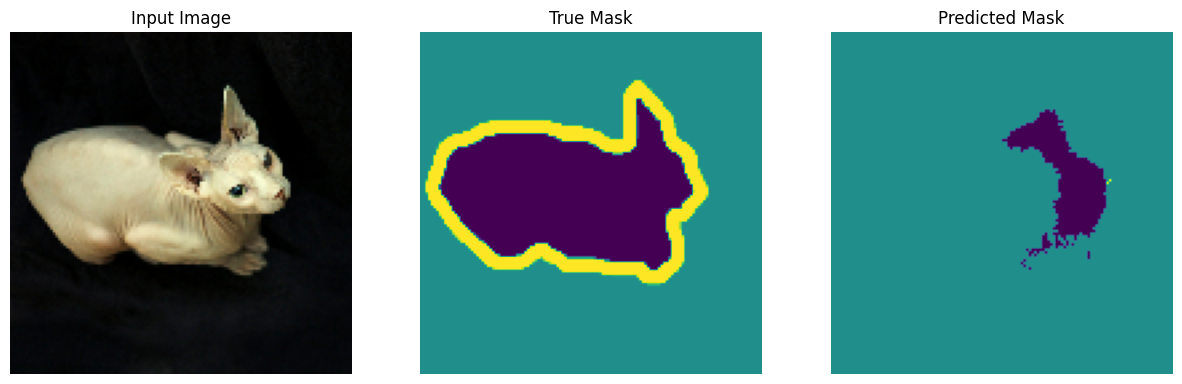


Sample Prediction after epoch 6

920/920 [==============================] - 23s 25ms/step - loss: 0.4804 - accuracy: 0.8001 - val_loss: 0.8911 - val_accuracy: 0.6935
Epoch 7/20
918/920 [============================>.] - ETA: 0s - loss: 0.4421 - accuracy: 0.8150

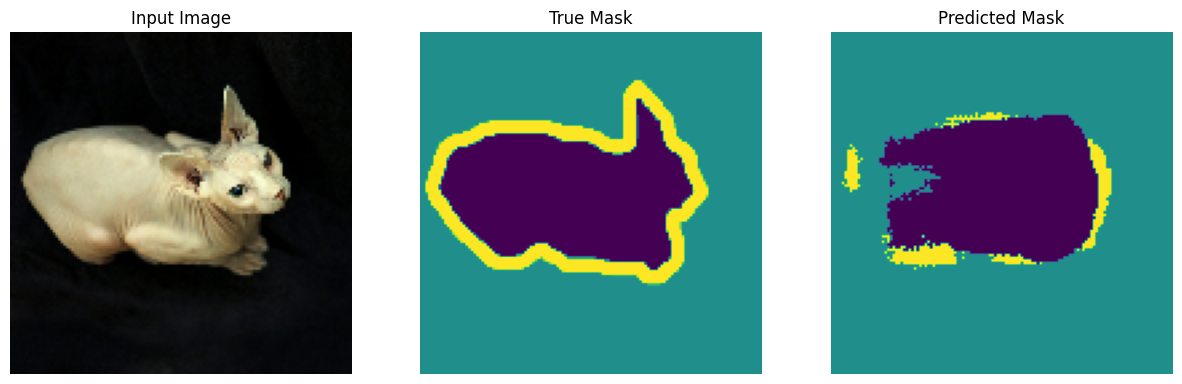


Sample Prediction after epoch 7

920/920 [==============================] - 23s 25ms/step - loss: 0.4421 - accuracy: 0.8150 - val_loss: 0.5276 - val_accuracy: 0.7849
Epoch 8/20
919/920 [============================>.] - ETA: 0s - loss: 0.4008 - accuracy: 0.8306

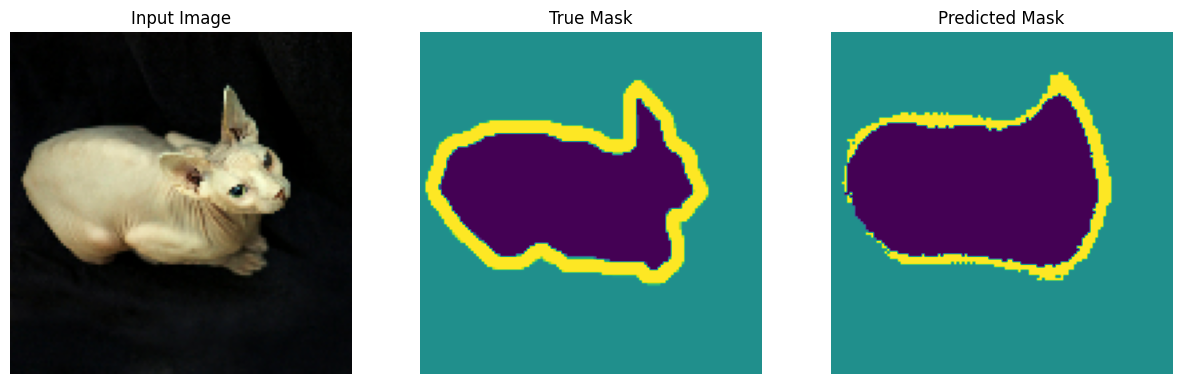


Sample Prediction after epoch 8

920/920 [==============================] - 23s 25ms/step - loss: 0.4006 - accuracy: 0.8306 - val_loss: 0.5330 - val_accuracy: 0.7903
Epoch 9/20
920/920 [==============================] - ETA: 0s - loss: 0.3566 - accuracy: 0.8473

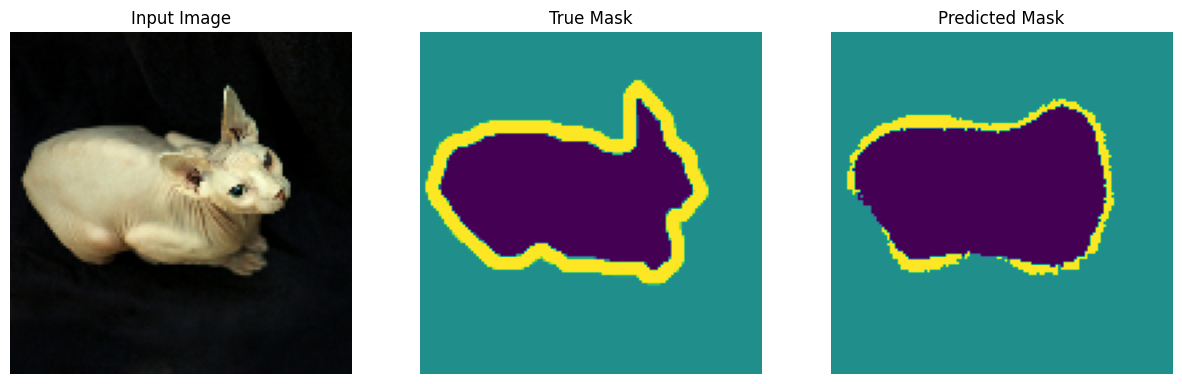


Sample Prediction after epoch 9

920/920 [==============================] - 23s 25ms/step - loss: 0.3566 - accuracy: 0.8473 - val_loss: 0.5320 - val_accuracy: 0.7927
Epoch 10/20
918/920 [============================>.] - ETA: 0s - loss: 0.3169 - accuracy: 0.8621

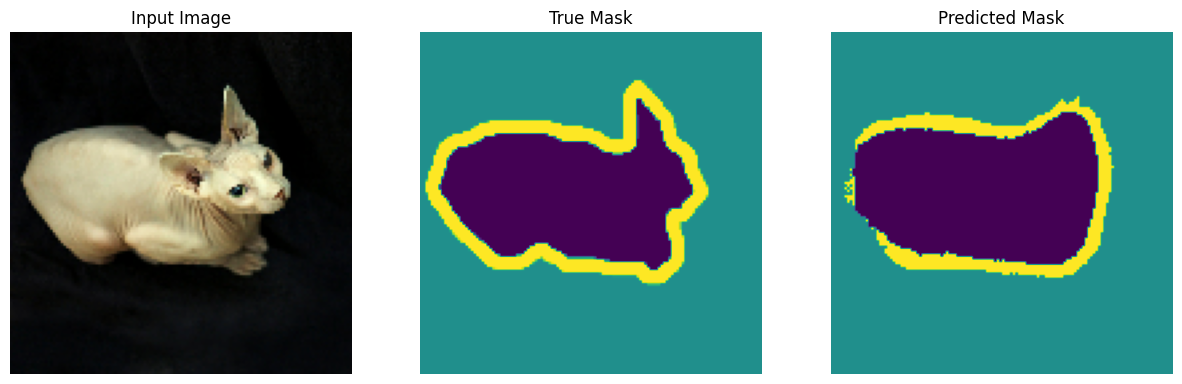


Sample Prediction after epoch 10

920/920 [==============================] - 23s 25ms/step - loss: 0.3169 - accuracy: 0.8621 - val_loss: 0.5261 - val_accuracy: 0.7985
Epoch 11/20
920/920 [==============================] - ETA: 0s - loss: 0.2868 - accuracy: 0.8734

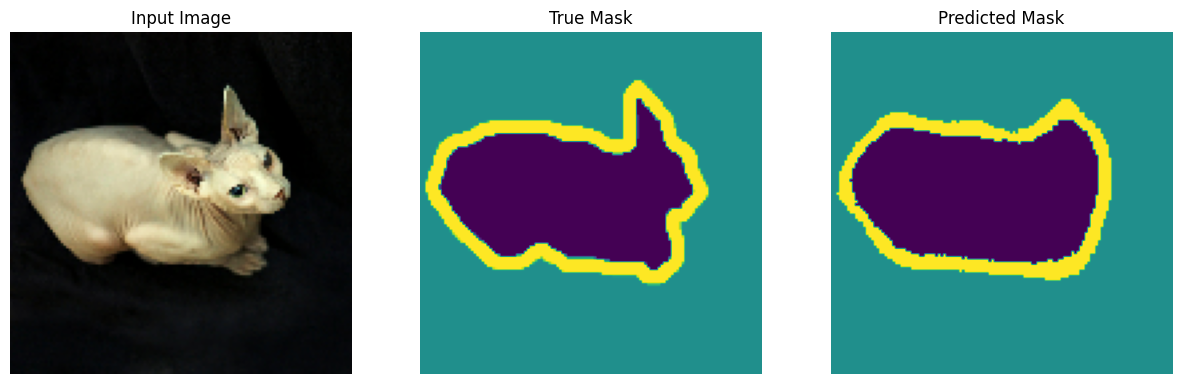


Sample Prediction after epoch 11

920/920 [==============================] - 23s 25ms/step - loss: 0.2868 - accuracy: 0.8734 - val_loss: 0.5361 - val_accuracy: 0.8018
Epoch 12/20
918/920 [============================>.] - ETA: 0s - loss: 0.2613 - accuracy: 0.8834

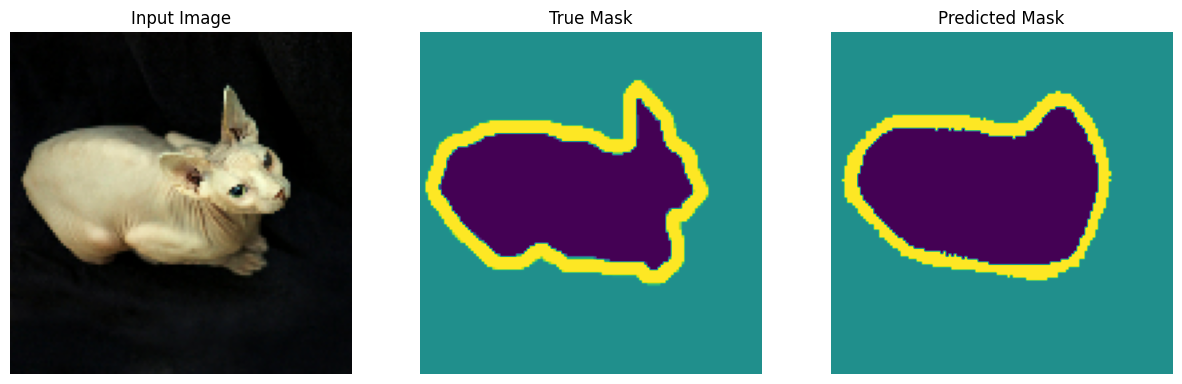


Sample Prediction after epoch 12

920/920 [==============================] - 23s 25ms/step - loss: 0.2611 - accuracy: 0.8835 - val_loss: 0.5931 - val_accuracy: 0.7965
Epoch 13/20
919/920 [============================>.] - ETA: 0s - loss: 0.2443 - accuracy: 0.8901

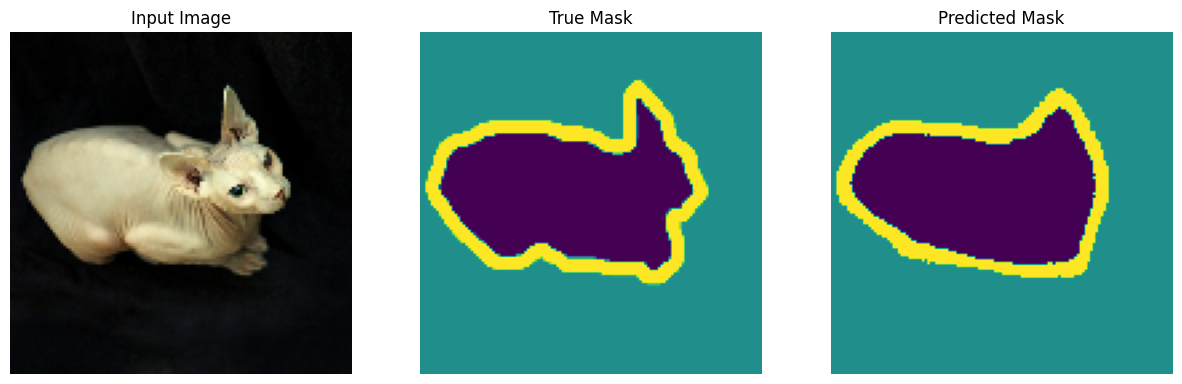


Sample Prediction after epoch 13

920/920 [==============================] - 23s 25ms/step - loss: 0.2443 - accuracy: 0.8902 - val_loss: 0.5739 - val_accuracy: 0.8022
Epoch 14/20
919/920 [============================>.] - ETA: 0s - loss: 0.2251 - accuracy: 0.8981

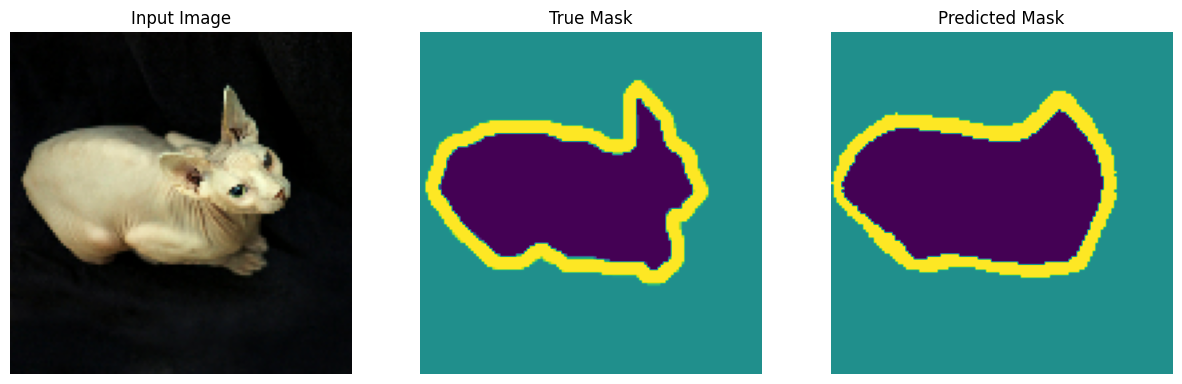


Sample Prediction after epoch 14

920/920 [==============================] - 23s 25ms/step - loss: 0.2251 - accuracy: 0.8981 - val_loss: 0.5637 - val_accuracy: 0.8012
Epoch 15/20
919/920 [============================>.] - ETA: 0s - loss: 0.2144 - accuracy: 0.9027

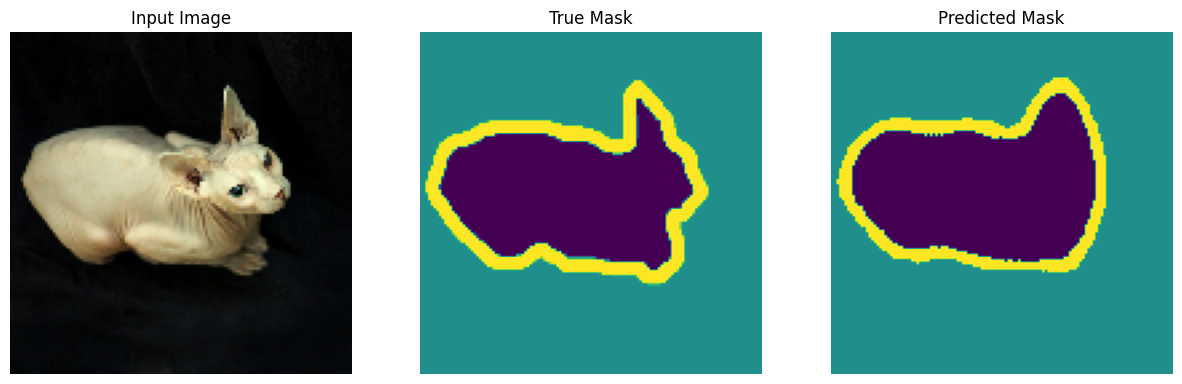


Sample Prediction after epoch 15

920/920 [==============================] - 23s 24ms/step - loss: 0.2144 - accuracy: 0.9027 - val_loss: 0.5988 - val_accuracy: 0.8011
Epoch 16/20
919/920 [============================>.] - ETA: 0s - loss: 0.2058 - accuracy: 0.9066

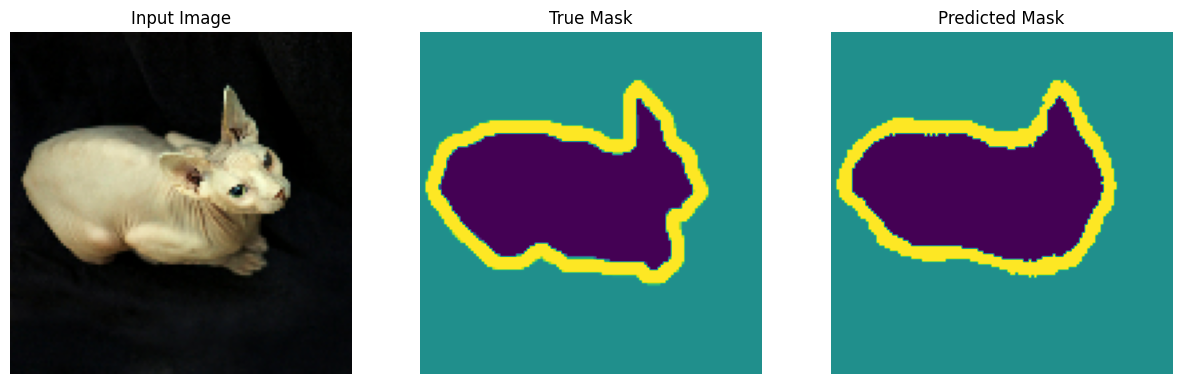


Sample Prediction after epoch 16

920/920 [==============================] - 22s 24ms/step - loss: 0.2058 - accuracy: 0.9065 - val_loss: 0.6267 - val_accuracy: 0.7972
Epoch 17/20
919/920 [============================>.] - ETA: 0s - loss: 0.1863 - accuracy: 0.9146

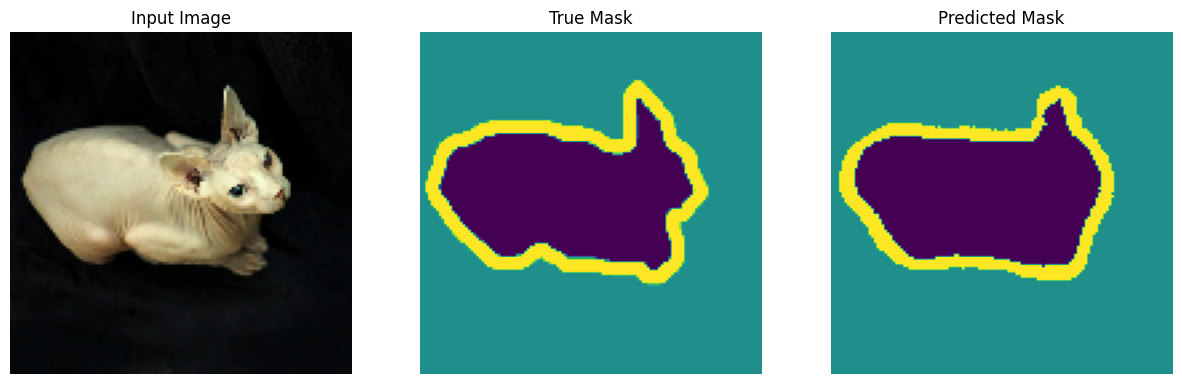


Sample Prediction after epoch 17

920/920 [==============================] - 22s 24ms/step - loss: 0.1864 - accuracy: 0.9146 - val_loss: 0.6452 - val_accuracy: 0.8017
Epoch 18/20
919/920 [============================>.] - ETA: 0s - loss: 0.1734 - accuracy: 0.9201

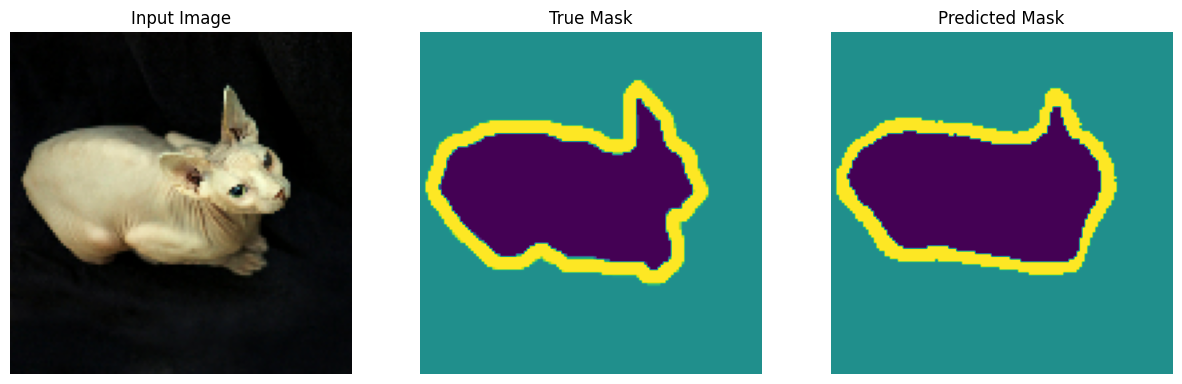


Sample Prediction after epoch 18

920/920 [==============================] - 23s 24ms/step - loss: 0.1735 - accuracy: 0.9201 - val_loss: 0.6818 - val_accuracy: 0.8016
Epoch 19/20
918/920 [============================>.] - ETA: 0s - loss: 0.1678 - accuracy: 0.9227

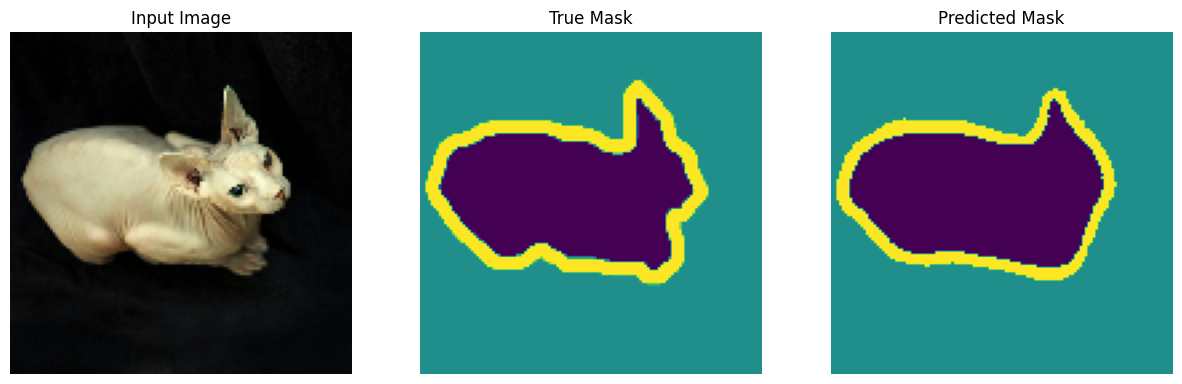


Sample Prediction after epoch 19

920/920 [==============================] - 24s 26ms/step - loss: 0.1678 - accuracy: 0.9227 - val_loss: 0.6788 - val_accuracy: 0.8019
Epoch 20/20
919/920 [============================>.] - ETA: 0s - loss: 0.1595 - accuracy: 0.9263

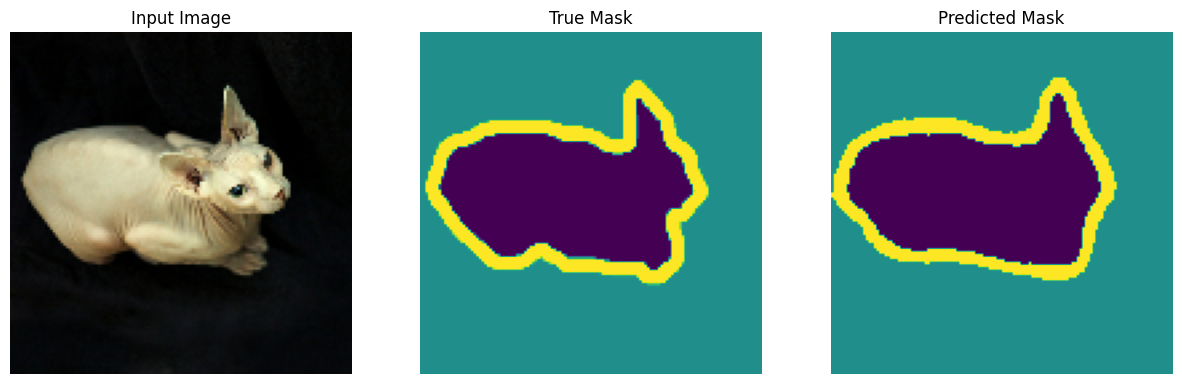


Sample Prediction after epoch 20

920/920 [==============================] - 24s 26ms/step - loss: 0.1595 - accuracy: 0.9263 - val_loss: 0.6877 - val_accuracy: 0.8027


In [9]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

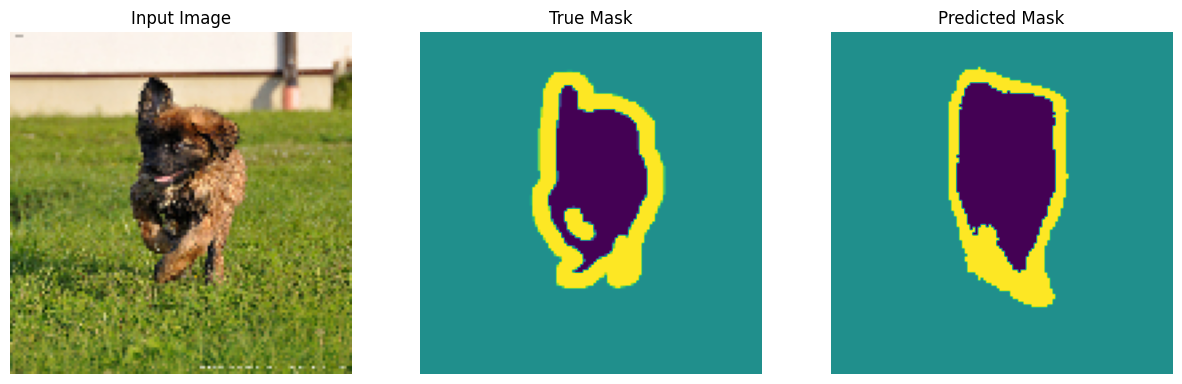

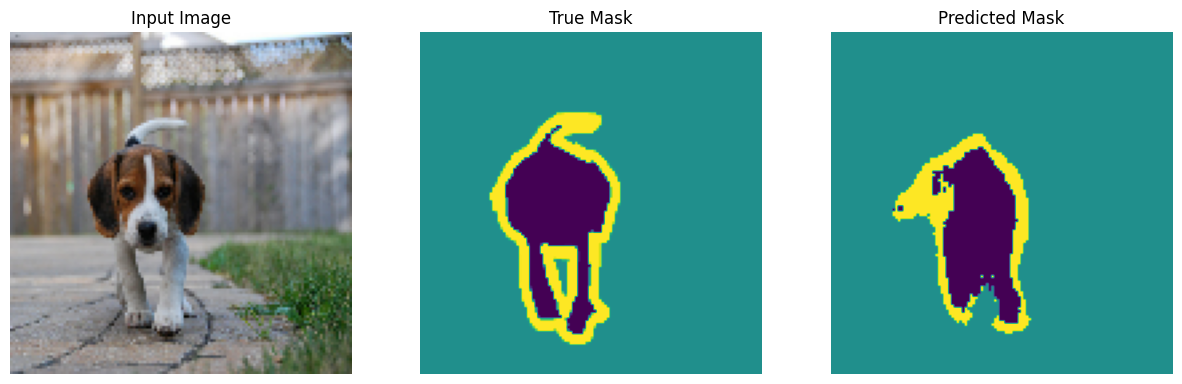

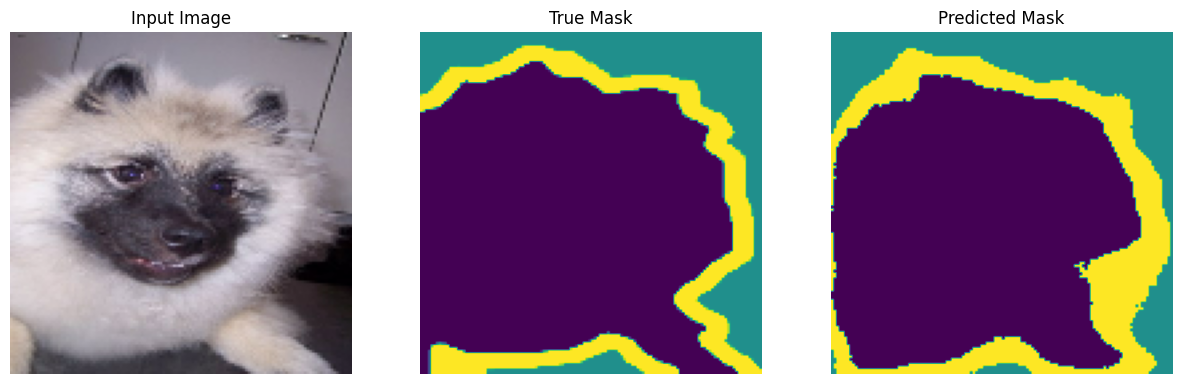

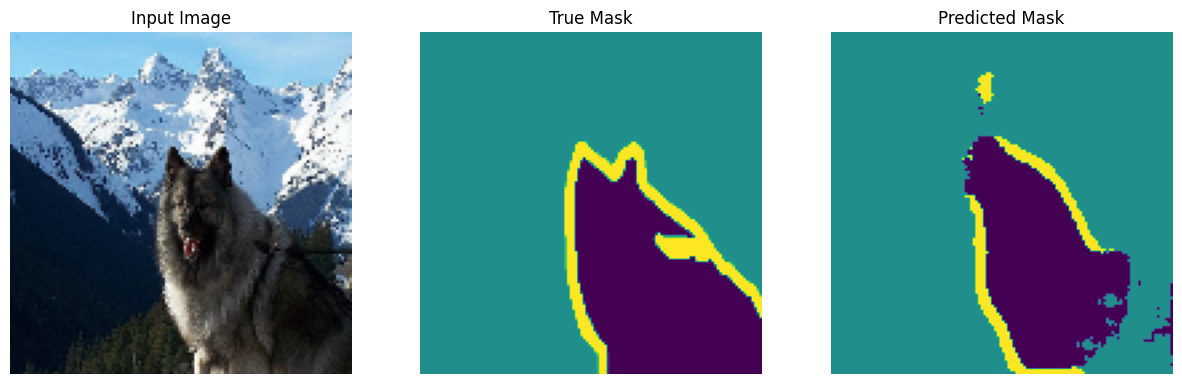

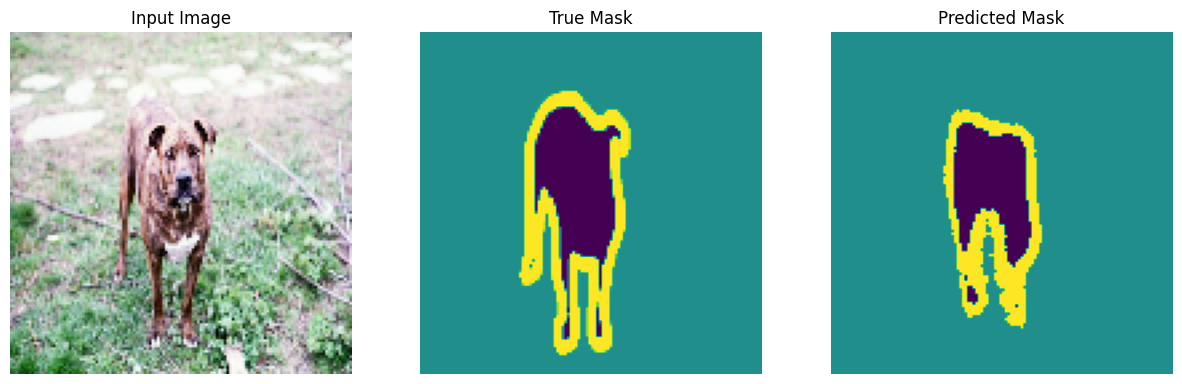

In [10]:
show_predictions(test_dataset, 5)